# CASE

Ingin dilakukan analisis sentimen mengenai pembelajaran yang sudah kembali bertatap muka atau Pembelajaran Tatap Muka (PTM). Data diambil dari Twitter dengan menggunakan beberapa kata kunci yaitu: 'pembelajaran tatap muka', 'sekolah tatap muka', 'belajar tatap muka', 'kuliah tatap muka', 'sekolah offline', 'kuliah offline', 'belajar offline', 'sekolah PTM', 'belajar PTM'.

Analisis sentimen akan dilakukan dengan menggunakan textblob dan vader. Selanjutnya dibentuk model ML berbasis K-Nearest Neighbour (KNN) terhadap hasil sentimen. Kemudian model tersebut diuji keakurasiannya sehingga tergambar seberapa baik model ini dalam mengklasifikasikan hasil analisis sentimen tersebut. 

## A. Modul yang Diperlukan

***

In [1]:
import pandas as pd
import numpy as np
import re
import swifter
import seaborn as sns
import matplotlib.pyplot as plt
import string
import plotly.express as px
import nltk
from nltk.tokenize import api, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from textblob import TextBlob
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from googletrans import Translator
from nltk.sentiment.vader import SentimentIntensityAnalyzer as vad
from prettytable import PrettyTable
from sklearn.decomposition import PCA

***

## B. Data yang Digunakan

Data sudah ditarik sebelumnya. Dari hasil penarikan itu, terdapat 5000+ data tweet yang diperoleh dengan mengecualikan tweet yang bersifat retweet.

In [3]:
# tweet sudah ditarik dengan API, sehingga dapat dibentuk dataframe sebagai berikut
rawtwit = pd.read_excel('ptm_tweet_fin.xlsx')
rawtwit.head(6)

created_at timestamp     screen_name  \
0 2022-05-24  08:00:00  bilansnafsizha   
1 2022-05-24  15:50:58       amandonut   
2 2022-05-28  08:45:59     sigit_prmna   
3 2022-05-29  11:37:59    nctzenmantul   
4 2022-05-25  01:30:44       Triafunny   
5 2022-05-28  00:18:35     lapasklaten   

                                                text  source  
0  Alhamdulillah sekolah anak sudah mulai diberla...     NaN  
1  SORRY YA kelas selsai jam 11 FOR 2 YEARSSS (di...     NaN  
2  Puan bersyukur Indonesia mulai memasuki fase e...     NaN  
3         besok hari pertama ikut kuliah offline....     NaN  
4  Balik dinas, disuruh belajar. Sempet agak shoc...     NaN  
5  41.KAKANWIL A YUSPAHRUDDIN KEMENKUMHAM JATENG:...     NaN

In [4]:
# untuk simplifikasi analisis, kita hanya mengambil kolom 'text' saja
dftwit = rawtwit['text']
dftwit = pd.DataFrame(dftwit)
dftwit.shape

(5209, 1)

Total terdapat 5209 line tweet (tidak termasuk yang berbentuk Retweet)

***

## C. Preprocessing Text

Data text berupa tweet memerlukan proses 'pembersihan'. Beberapa proses tersebut diantaranya adalah menghilangkan tweet kosong, menghilangkan duplikasi, menghilangkan tanda baca berlebihan, dan sebagainya.

In [5]:
# cek dan menghilangkan apabila ada yang tweet kosong / 'na'
dftwit.dropna(inplace = True)

In [6]:
# cek dan menghilangkan apabila ada yang duplikasi
dftwit.drop_duplicates(subset = 'text', keep = 'first', inplace = True)
dftwit.shape

(4598, 1)

Ternyata setelah dihilangkan NA dan duplikasi jumlah Tweet, data tereduksi dari 5209 menjadi 4598.
Langkah selanjutnya adalah melakukan text preprocessing lanjutan.

In [7]:
# membuat beberapa fungsi untuk preprocessing text

def cleanusername(dftwit):
    return re.sub('@[^\s]+','',dftwit)

def cleanRT(dftwit):
    return re.sub('RT','',dftwit)

def remove_tweet_special(dftwit):
    dftwit = re.sub('\s+',' ',dftwit)
    dftwit = dftwit.encode('ascii', 'replace').decode('ascii')
    return re.sub(r'http\S+', '', dftwit)

def lower_case(dftwit):
  return dftwit.lower()

def remove_punctuation(dftwit):
  return dftwit.translate(str.maketrans("","",string.punctuation))

def remove_number(dftwit) :
  return re.sub(r"\d+", "", dftwit)

def remove_singl_char(dftwit):
  return re.sub(r"\b[a-zA-Z]\b", "", dftwit)

def remove_whitespace_LT(dftwit):
  return dftwit.strip()

def remove_whitespace_multiple(dftwit):
  return re.sub('\s+',' ',dftwit)

def replaceThreeOrMore(dftwit):
  pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
  return pattern.sub(r"\1\1", dftwit)

In [8]:
dftwit['text'] = dftwit['text'].apply(cleanusername)
dftwit['text'] = dftwit['text'].apply(cleanRT)
dftwit['text'] = dftwit['text'].apply(remove_tweet_special)
dftwit['text'] = dftwit['text'].apply(lower_case)
dftwit['text'] = dftwit['text'].apply(remove_punctuation)
dftwit['text'] = dftwit['text'].apply(remove_number)
dftwit['text'] = dftwit['text'].apply(remove_singl_char)
dftwit['text'] = dftwit['text'].apply(remove_whitespace_LT)
dftwit['text'] = dftwit['text'].apply(remove_whitespace_multiple)
dftwit['text'] = dftwit['text'].apply(replaceThreeOrMore)
dftwit.head(6)

text
0  alhamdulillah sekolah anak sudah mulai diberla...
1  sorry ya kelas selsai jam for yearss di sekola...
2  puan bersyukur indonesia mulai memasuki fase e...
3             besok hari pertama ikut kuliah offline
4  balik dinas disuruh belajar sempet agak shock ...
5  kakanwil yuspahruddin kemenkumham jateng hadap...

Preprocessing berlanjut dengan coba menghilangkan stopword, mengembalikan dalam bentuk kata baku, membuat token berdasarkan kata yang nantinya akan disusun kembali dalam bentuk kalimat.

In [9]:
dftwit2 = dftwit.copy()

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\RISMAN MOH
[nltk_data]     RIZAL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
def word_tokenize_wrapper(dftwit2):
  return word_tokenize(dftwit2)

In [14]:
dftwit2['text'] = dftwit2['text'].apply(word_tokenize_wrapper)
dftwit2.head(6)

text
0  [alhamdulillah, sekolah, anak, sudah, mulai, d...
1  [sorry, ya, kelas, selsai, jam, for, yearss, d...
2  [puan, bersyukur, indonesia, mulai, memasuki, ...
3      [besok, hari, pertama, ikut, kuliah, offline]
4  [balik, dinas, disuruh, belajar, sempet, agak,...
5  [kakanwil, yuspahruddin, kemenkumham, jateng, ...

Selanjutnya kita perlu menormalisasi tiap kata yang ada. Dengan menggunakan kamus mandiri sebagaimana berikut, kata yang teridentifikasi akan dinormalisasi sebagaimana mestinya.

In [15]:
sheet_id = '1ke3yJfIB0OsZZBK5rD8dJX4pxRWsA84UG_RVMNVrs9s'
katabaku = pd.read_csv(f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv')

In [16]:
katabaku.head()

BEFORE        AFTER
0      gua         saya
1       gw         saya
2    mngkn      mungkin
3     prnh       pernah
4  brdsrkn  berdasarkan

In [17]:
katanormal = pd.Series(katabaku.AFTER.values, index = katabaku.BEFORE).to_dict()

In [19]:
def normalized_kata(document):
  return [katanormal[term] if term in katanormal else term for term in document]

In [20]:
dftwit2['text'] = dftwit2['text'].apply(normalized_kata)
dftwit2.head(6)

text
0  [alhamdulillah, sekolah, anak, sudah, mulai, d...
1  [sorry, ya, kelas, selsai, jam, for, yearss, d...
2  [puan, bersyukur, indonesia, mulai, memasuki, ...
3      [besok, hari, pertama, ikut, kuliah, offline]
4  [balik, dinas, disuruh, belajar, sempet, agak,...
5  [kakanwil, yuspahruddin, kemenkumham, jateng, ...

Tidak sampai disitu, penyaringan kata melalui proses normalisasi dilakukan kembali dengan menggunakan Colloquial Indonesian Lexicon yang diambil dari https://github.com/nasalsabila/kamus-alay.

In [23]:
kataalay = pd.read_csv('colloquial-indonesian-lexicon.txt')
kataalay.head(6)

slang    formal
0      woww       wow
1     aminn      amin
2       met   selamat
3    netaas   menetas
4   keberpa  keberapa
5  eeeehhhh        eh

In [24]:
kataformal = pd.Series(kataalay.formal.values, index = kataalay.slang).to_dict()

def formalized_kata(document):
  return [kataformal[term] if term in kataformal else term for term in document]

In [25]:
dftwit2['text'] = dftwit2['text'].apply(formalized_kata)
dftwit2.head(6)

text
0  [alhamdulillah, sekolah, anak, sudah, mulai, d...
1  [sorry, ya, kelas, selsai, jam, for, yearss, d...
2  [puan, bersyukur, indonesia, mulai, memasuki, ...
3      [besok, hari, pertama, ikut, kuliah, offline]
4  [balik, dinas, disuruh, belajar, sempat, agak,...
5  [kakanwil, yuspahruddin, kemenkumham, jateng, ...

Menghilangkan stopwords

In [26]:
def unTokenize(dftwit2) :
  return TreebankWordDetokenizer().detokenize(dftwit2)

In [27]:
dftwit2['text'] = dftwit2['text'].apply(unTokenize)
dftwit2['text'] = dftwit2['text'].apply(word_tokenize_wrapper)

In [28]:
nltk.download('stopwords')
list_stopwords = stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to C:\Users\RISMAN MOH
[nltk_data]     RIZAL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
list_stopwords = set(list_stopwords)
exclude_words = {"tidak", "bukan", "jangan"}
new_stop_words = list_stopwords.difference(exclude_words)

def stopwords_removal(dftwit2):
  return [tweets for tweets in dftwit2 if tweets not in new_stop_words]

dftwit2['text'] = dftwit2['text'].apply(stopwords_removal)

Selanjutnya, kita menggabungkan kembali kata-kata tersebut dalam bentuk kalimat utuh. 

In [30]:
dftwit3 = dftwit2.copy()

dftwit3['text'] = dftwit3['text'].apply(unTokenize)
dftwit3.head(6)

text
0  alhamdulillah sekolah anak diberlakukannya ptm...
1  sorry ya kelas selsai jam for yearss sekolah p...
2  puan bersyukur indonesia memasuki fase endemi ...
3                               besok kuliah offline
4  dinas disuruh belajar shock kalo disuruh offli...
5  kakanwil yuspahruddin kemenkumham jateng hadap...

In [31]:
dftwit3.shape

(4598, 1)

Preprocessing selesai.

***

## D. Analisis Sentimen

Sentimen akan dilakukan dengan dua pendekatan yaitu Vader dan TextBlob. Hasil keduanya kemudian akan dibandingkan. 

Data tweet yang ditarik berbahasa Indonesia, oleh karena itu dalam menganalisis sentimen idealnya perlu diubah ke dalam bahasa yang mengakomodasi analisis sentimen. Untuk mengatasi hal tersebut, kita memanfaatkan fitur pada modul `googletrans` dengan fungsi Translator. Idenya adalah dalam menentukan sentimen nanti data tweet akan diterjemahkan terlebih dahulu (apa adanya) ke dalam bahasa Inggris. 

Walaupun demikian, `googletrans` ini pun memiliki keterbatasan maksimum query (karena menggunakan free API).

***

### D.1. Translasi Tweet

Melakukan translasi dengan menggunakan googletrans terdapat beberapa keterbatasan terutama dari sisi jumlah string. Oleh karena itu kita siasati dengan membagi jumlah data tweet ke dalam dataframe lain dengan jumlah maksimum tweet sebanyak 500 buah.

In [33]:
S = 500
N = int(len(dftwit3)/S)
frames = [dftwit3.iloc[i*S:(i+1)*S].copy() for i in range(N+1) ]

In [34]:
trans0 = frames[0].copy()
trans1 = frames[1].copy()
trans2 = frames[2].copy()
trans3 = frames[3].copy()
trans4 = frames[4].copy()
trans5 = frames[5].copy()
trans6 = frames[6].copy()
trans7 = frames[7].copy()
trans8 = frames[8].copy()
trans9 = frames[9].copy()

In [35]:
trans0['text_en'] = trans0['text'].apply(translator.translate, 
                                              src = 'id', dest = 'en').apply(getattr, args = ('text',))

In [36]:
trans1['text_en'] = trans1['text'].apply(translator.translate, 
                                               src = 'id', dest = 'en').apply(getattr, args = ('text',))

In [37]:
trans2['text_en'] = trans2['text'].apply(translator.translate, 
                                               src = 'id', dest = 'en').apply(getattr, args = ('text',))

In [38]:
trans3['text_en'] = trans3['text'].apply(translator.translate, 
                                               src = 'id', dest = 'en').apply(getattr, args = ('text',))

In [39]:
trans4['text_en'] = trans4['text'].apply(translator.translate, 
                                               src = 'id', dest = 'en').apply(getattr, args = ('text',))

In [40]:
trans5['text_en'] = trans5['text'].apply(translator.translate, 
                                               src = 'id', dest = 'en').apply(getattr, args = ('text',))

In [41]:
trans6['text_en'] = trans6['text'].apply(translator.translate, 
                                               src = 'id', dest = 'en').apply(getattr, args = ('text',))

In [42]:
trans7['text_en'] = trans7['text'].apply(translator.translate, 
                                               src = 'id', dest = 'en').apply(getattr, args = ('text',))

In [44]:
trans8['text_en'] = trans8['text'].apply(translator.translate, 
                                               src = 'id', dest = 'en').apply(getattr, args = ('text',))

In [45]:
trans9['text_en'] = trans9['text'].apply(translator.translate, 
                                               src = 'id', dest = 'en').apply(getattr, args = ('text',))

In [46]:
dftwit4 = pd.concat([trans0, trans1, trans2, trans3, trans4,
                     trans5, trans6, trans7, trans8, trans9])

In [47]:
dftwit4.head(6)

text  \
0  alhamdulillah sekolah anak diberlakukannya ptm...   
1  sorry ya kelas selsai jam for yearss sekolah p...   
2  puan bersyukur indonesia memasuki fase endemi ...   
3                               besok kuliah offline   
4  dinas disuruh belajar shock kalo disuruh offli...   
5  kakanwil yuspahruddin kemenkumham jateng hadap...   

                                             text_en  
0  Alhamdulillah, the children's school is applie...  
1  Sorry, Classi Class Jam For Yearss School home...  
2  Puan grateful that Indonesia entered the Pande...  
3                        Tomorrow is offline college  
4  Service is told to learn shock if told to offl...  
5  Kakanwil Yuspahruddin Kemenkumham Central Java...

In [50]:
dftwit4.to_csv("hasil_translate.csv")

Proses translasi selesai.

***

### D.2. Sentimen Menggunakan Vader

In [51]:
tf_data = TfidfVectorizer()

# buat dataframe baru
vader_sentimen = dftwit4.copy()

sentiment = vad()
sen = ['Positive','Negative','Neutral']
sentiments = [sentiment.polarity_scores(i) for i in vader_sentimen['text_en'].values]
vader_sentimen['Negative Score'] = [i['neg'] for i in sentiments]
vader_sentimen['Positive Score'] = [i['pos'] for i in sentiments]
vader_sentimen['Neutral Score'] = [i['neu'] for i in sentiments]
vader_sentimen['Compound Score'] = [i['compound'] for i in sentiments]
score = vader_sentimen['Compound Score'].values

t=[]
for i in score:
    if i >=0.05 :
        t.append('Positive')
    elif i<=-0.05 :
        t.append('Negative')
    else:
        t.append('Neutral')
vader_sentimen['Sentiment Vader'] = t

In [52]:
vader_sentimen.head(6)

text  \
0  alhamdulillah sekolah anak diberlakukannya ptm...   
1  sorry ya kelas selsai jam for yearss sekolah p...   
2  puan bersyukur indonesia memasuki fase endemi ...   
3                               besok kuliah offline   
4  dinas disuruh belajar shock kalo disuruh offli...   
5  kakanwil yuspahruddin kemenkumham jateng hadap...   

                                             text_en  Negative Score  \
0  Alhamdulillah, the children's school is applie...           0.000   
1  Sorry, Classi Class Jam For Yearss School home...           0.132   
2  Puan grateful that Indonesia entered the Pande...           0.000   
3                        Tomorrow is offline college           0.333   
4  Service is told to learn shock if told to offl...           0.153   
5  Kakanwil Yuspahruddin Kemenkumham Central Java...           0.000   

   Positive Score  Neutral Score  Compound Score Sentiment Vader  
0           0.000          1.000          0.0000         Neutral  
1           0.074          0.794          0.0000         Neutral  
2           0.143          0.857          0.4588        Positive  
3           0.000          0.667         -0.1280        Negative  
4           0.138          0.709          0.1531        Positive  
5           0.000          1.000          0.0000         Neutral

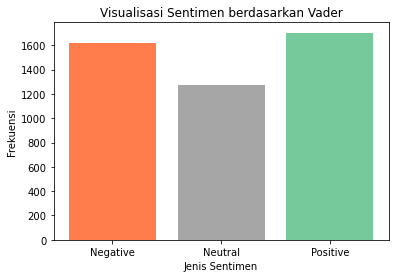

In [53]:
# kemudian kita buatkan bar chart untuk mengetahui distribusi dari sentimen keseluruhan yang dihasilkan

label_vader = vader_sentimen.groupby('Sentiment Vader').count().index.values
value_vader = vader_sentimen.groupby('Sentiment Vader').size().values
plt.bar(label_vader, value_vader, color = ['orangered', 'gray', 'mediumseagreen'], alpha = 0.7)
plt.ylabel('Frekuensi')
plt.xlabel('Jenis Sentimen')
plt.title('Visualisasi Sentimen berdasarkan Vader')
plt.show()

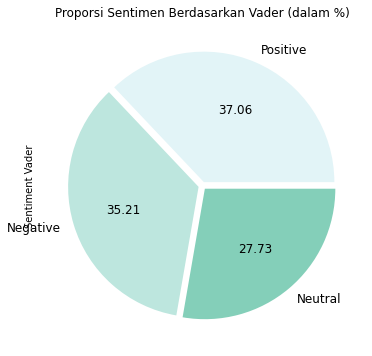

In [56]:
# dibuatkan pula pie chart untuk menggambarkan proporsi masing-masing sentiment
colors = sns.color_palette('BuGn')
pd.Series(vader_sentimen['Sentiment Vader']).value_counts().plot(kind = 'pie', 
                                                                 colors = colors, 
                                                                 labels = ['Positive','Negative','Neutral'], 
                                                                 explode = [0.03,0.03,0.03], autopct = '%.2f',
                                                                 fontsize = 12, figsize=(6,6), 
                                                                 title = "Proporsi Sentimen Berdasarkan Vader (dalam %)")
plt.show()

***

### D.3. Sentimen Menggunakan TextBlob

In [57]:
blob_sentimen = dftwit4.copy()

In [58]:
# polarity

def getPolarity(blob_sentimen):
    analysis = TextBlob(blob_sentimen)   
    return analysis.sentiment.polarity

blob_sentimen['Polarity'] = blob_sentimen['text_en'].apply(getPolarity)

In [59]:
# subjectivity

def getSubjectivity(blob_sentimen):
    analysis = TextBlob(blob_sentimen)
    return analysis.sentiment.subjectivity

blob_sentimen['Subjectivity'] = blob_sentimen['text_en'].apply(getSubjectivity)

In [60]:
# klasifikasi sentimen berdasarkan polaritas

def getClass(val):
    if val < 0:
        return 'Negative'
    if val == 0:
        return 'Neutral'
    else:
        return 'Positive'

blob_sentimen['Sentiment Blob'] = blob_sentimen['Polarity'].apply(getClass)

In [61]:
blob_sentimen.head(6)

text  \
0  alhamdulillah sekolah anak diberlakukannya ptm...   
1  sorry ya kelas selsai jam for yearss sekolah p...   
2  puan bersyukur indonesia memasuki fase endemi ...   
3                               besok kuliah offline   
4  dinas disuruh belajar shock kalo disuruh offli...   
5  kakanwil yuspahruddin kemenkumham jateng hadap...   

                                             text_en  Polarity  Subjectivity  \
0  Alhamdulillah, the children's school is applie...      0.00      0.000000   
1  Sorry, Classi Class Jam For Yearss School home...     -0.25      0.666667   
2  Puan grateful that Indonesia entered the Pande...      0.00      0.000000   
3                        Tomorrow is offline college      0.00      0.000000   
4  Service is told to learn shock if told to offl...      0.50      0.650000   
5  Kakanwil Yuspahruddin Kemenkumham Central Java...      0.00      0.250000   

  Sentiment Blob  
0        Neutral  
1       Negative  
2        Neutral  
3        Neutral  
4       Positive  
5        Neutral

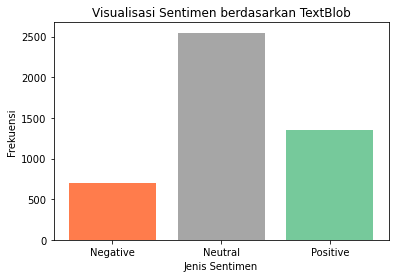

In [62]:
# bar chart sentimen berdasarkan TextBlob

label_twit = blob_sentimen.groupby('Sentiment Blob').count().index.values
value_twit = blob_sentimen.groupby('Sentiment Blob').size().values
plt.bar(label_twit, value_twit, color=['orangered', 'gray', 'mediumseagreen'], alpha = 0.7)
plt.ylabel('Frekuensi')
plt.xlabel('Jenis Sentimen')
plt.title('Visualisasi Sentimen berdasarkan TextBlob')
plt.show()

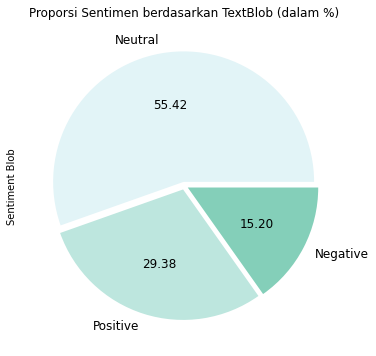

In [63]:
# pie chart
colors = sns.color_palette('BuGn')
pd.Series(blob_sentimen['Sentiment Blob']).value_counts().plot(kind = 'pie', colors = colors, 
                                                          labels=['Neutral','Positive','Negative'], 
                                                          explode = [0.03,0.03,0.03], autopct = '%.2f', 
                                                          fontsize = 12, figsize = (6,6), 
                                                          title="Proporsi Sentimen berdasarkan TextBlob (dalam %)")

plt.show()

### D.4. Perbandingan Hasil Sentimen

Berdasarkan kedua analisis sentimen tersebut, dapat dibandingkan prorposi pada masing-masing label polarity sebagai berikut:

In [64]:
myTable = PrettyTable(["Label", "% via Vader", "% via TextBlob"])

myTable.add_row(["Positive", "37.06", "29.38"])
myTable.add_row(["Negative", "35.21", "15.20"])
myTable.add_row(["Neutral", "27.73", "55.42"])

print(myTable)

+----------+-------------+----------------+
|  Label   | % via Vader | % via TextBlob |
+----------+-------------+----------------+
| Positive |    37.06    |     29.38      |
| Negative |    35.21    |     15.20      |
| Neutral  |    27.73    |     55.42      |
+----------+-------------+----------------+


Dari hasil tersebut nampak bahwa sentimen menggunakan Vader lebih menggambarkan kelas yang seimbang. Adapun sentimen berdasarkan TextBlob lebih dominan pada Netral. 

Kemudian akan coba divisualisasikan hasil sentimen tersebut sebagai berikut:

In [65]:
# sesi Vader
vader_pca = tf_data.fit_transform(vader_sentimen['text_en'].values)
pca_vader = PCA(n_components = 3).fit_transform(vader_pca.todense())

In [66]:
# 3D scatter plot
px.scatter_3d(x = pca_vader[:,0], y = pca_vader[:,1], z = pca_vader[:,2],
              color = vader_sentimen['Sentiment Vader'].values)

In [67]:
# sesi textblob
blob_pca = tf_data.fit_transform(blob_sentimen['text_en'].values)
pca_blob = PCA(n_components = 3).fit_transform(blob_pca.todense())

In [68]:
# 3D scatter TextBlob Sentiment Analysis
px.scatter_3d(x = pca_blob[:,0], y = pca_blob[:,1], z = pca_blob[:,2], 
              color = blob_sentimen['Sentiment Blob'].values)

Dari Kedua metode analisis sentiment tersebut, terdapat perbedaan polar sentimen yang dihasilkan, walaupun tidak terlalu signifikan berbeda. Langkah selanjutnya adalah membuat model serta menghitung akurasi dalam pengklasifikasian label sentimen. 

***

## E.  Membentuk Model KNN

Pada data ini, hanya terdapat satu feature yaitu ‘Sentimen’. Tujuannya adalah melatih model untuk dapat mengklasifikasikan text menjadi Positif, Negatif, atau Netral. Oleh karena itu X akan berupa text dari tweet adapun y adalah sentimen.

Model KNN akan dibangun berdasarkan dari dua hasil analisis sentimen (Vader dan TextBlob). Pada masing-masing akan dilakukan dua pendekatan lagi sebagai vektorisasi yaitu Count Vectorizer dan TFIDF Vectorizer. Tujuan utamanya adalah feature extraction (sebagai dasar dalam menghitung KNN) yaitu merepresentasikan setiap tweet dalam bentuk bag-of-words (BoW). BoW adalah kumpulan kata yang tidak berurutan dan tidak memperhatikan penekanan yang ditempatkan pada frekuensi masing-masing kata. 

Sebelumnya terlebih dahulu kita melakukan splitting data untuk training dan testing. 

### E.1. Splitting Data

In [116]:
vader_df = vader_sentimen[['text', 'text_en', 'Sentiment Vader']].copy()
blob_df = blob_sentimen[['text', 'text_en', 'Sentiment Blob']].copy()

In [153]:
X_vader = vader_df['text_en']
y_vader = vader_df['Sentiment Vader']

X_blob = blob_df['text_en']
y_blob = blob_df['Sentiment Blob']

In [89]:
from sklearn.neighbors import KNeighborsClassifier

### E.2. Model KNN Vader

In [147]:
X_train_vader, X_test_vader, y_train_vader, y_test_vader = train_test_split(X_vader, y_vader,
                                                                            test_size = 0.3, random_state = 2048)

In [166]:
neighbors = list(range(3, 50, 2))

akurasi_vader = []

for k in neighbors:
    cv = CountVectorizer()
    ctmTr_vader = cv.fit_transform(X_train_vader)
    X_test_dtm_vader = cv.transform(X_test_vader)
    knn_vader = KNeighborsClassifier(n_neighbors = k)
    knn_vader.fit(ctmTr_vader, y_train_vader)
    knn_score_vader = knn_vader.score(X_test_dtm_vader, y_test_vader)
    akurasi_vader.append(knn_score_vader.mean())

The optimal number of neighbors is 3


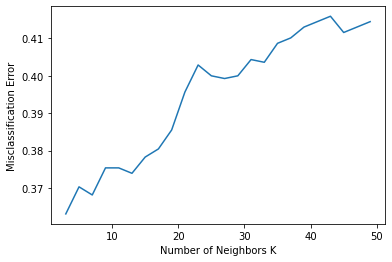

In [167]:
mse_vader = [1 - x for x in akurasi_vader]

# determining best k
optimal_k_vader = neighbors[mse_vader.index(min(mse_vader))]
print("The optimal number of neighbors is {}".format(optimal_k_vader))

# plot misclassification error vs k
plt.plot(neighbors, mse_vader)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Misclassification Error")
plt.show()

In [168]:
# nilai k optimal adalah k = 3
ctmTr_vader = cv.fit_transform(X_train_vader)
X_test_dtm_vader = cv.transform(X_test_vader)

knn_vader = KNeighborsClassifier(n_neighbors = 3)
knn_vader.fit(ctmTr_vader, y_train_vader)
knn_score_vader = knn_vader.score(X_test_dtm_vader, y_test_vader)

print("Akurasi Model KNN Classifier (Vader) with CountVectorizer")
print(knn_score_vader)
y_pred_knn_vader = knn_vader.predict(X_test_dtm_vader)

#Confusion matrix
cm_knn_vader = confusion_matrix(y_test_vader, y_pred_knn_vader)

Akurasi Model KNN Classifier (Vader) with CountVectorizer
0.6369565217391304


In [169]:
cm_knn_vader

array([[349,  76,  51],
       [ 36, 342,  19],
       [191, 128, 188]], dtype=int64)

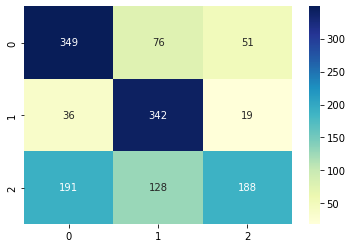

In [170]:
ax_vader = sns.heatmap(cm_knn_vader, annot = True, fmt = "d", cmap = "YlGnBu")

***

In [171]:
# menggunakan TFIDF
akurasi_vader2 = []

for k in neighbors:
    vectorizer = TfidfVectorizer()
    X_train_vec_vader = vectorizer.fit_transform(X_train_vader)
    X_test_vec_vader = vectorizer.transform(X_test_vader)
    knn_vader2 = KNeighborsClassifier(n_neighbors = k)
    knn_vader2.fit(X_train_vec_vader, y_train_vader)
    knn_score_vader2 = knn_vader2.score(X_test_vec_vader, y_test_vader)
    akurasi_vader2.append(knn_score_vader2.mean())

The optimal number of neighbors is 41


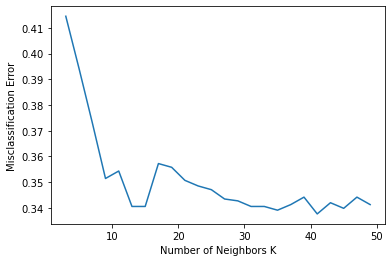

In [172]:
mse_vader2 = [1 - x for x in akurasi_vader2]

# determining best k
optimal_k_vader2 = neighbors[mse_vader2.index(min(mse_vader2))]
print("The optimal number of neighbors is {}".format(optimal_k_vader2))

# plot misclassification error vs k
plt.plot(neighbors, mse_vader2)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Misclassification Error")
plt.show()


In [173]:
vectorizer = TfidfVectorizer()
X_train_vec_vader = vectorizer.fit_transform(X_train_vader)
X_test_vec_vader = vectorizer.transform(X_test_vader)
knn_vader2 = KNeighborsClassifier(n_neighbors = 41)
knn_vader2.fit(X_train_vec_vader, y_train_vader)
knn_score_vader2 = knn_vader2.score(X_test_vec_vader, y_test_vader)
    
print("Akurasi Model KNN Classifier (Vader) with TFIDFVectorizer")
print(knn_score_vader2)
y_pred_knn_vader2 = knn_vader2.predict(X_test_vec_vader)

Akurasi Model KNN Classifier (Vader) with TFIDFVectorizer
0.6623188405797101


In [174]:
#Confusion matrix
cm_knn_vader2 = confusion_matrix(y_test_vader, y_pred_knn_vader2)

In [175]:
cm_knn_vader2

array([[389,  38,  49],
       [ 85, 266,  46],
       [202,  46, 259]], dtype=int64)

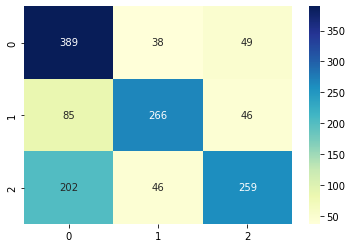

In [176]:
ax_vader2 = sns.heatmap(cm_knn_vader2, annot = True, fmt = "d", cmap = "YlGnBu")

Dari hasil tersebut dapat diperhatikan bahwa model KNN yang dibangun dengan TFIDF vectorizer sedikit lebih baik tingkat akurasinya dibandingkan dengan Count Vectorizer.

In [179]:
myTable2 = PrettyTable(["Metode pada Vader", "Akurasi KNN"])

myTable2.add_row(["Count Vectorizer", round(knn_score_vader, 2)])
myTable2.add_row(["TFIDF Vectorizer", round(knn_score_vader2, 2)])

print(myTable2)

+-------------------+-------------+
| Metode pada Vader | Akurasi KNN |
+-------------------+-------------+
|  Count Vectorizer |     0.64    |
|  TFIDF Vectorizer |     0.66    |
+-------------------+-------------+


***

### E.2. Model KNN TextBlob

In [182]:
X_train_blob, X_test_blob, y_train_blob, y_test_blob = train_test_split(X_blob, y_blob,
                                                                            test_size = 0.3, random_state = 2220)

In [183]:
akurasi_blob = []

for k in neighbors:
    cv = CountVectorizer()
    ctmTr_blob = cv.fit_transform(X_train_blob)
    X_test_dtm_blob = cv.transform(X_test_blob)
    knn_blob = KNeighborsClassifier(n_neighbors = k)
    knn_blob.fit(ctmTr_blob, y_train_blob)
    knn_score_blob = knn_blob.score(X_test_dtm_blob, y_test_blob)
    akurasi_blob.append(knn_score_blob.mean())

The optimal number of neighbors is 3


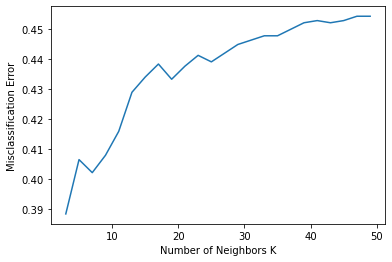

In [184]:
mse_blob = [1 - x for x in akurasi_blob]

# determining best k
optimal_k_blob = neighbors[mse_blob.index(min(mse_blob))]
print("The optimal number of neighbors is {}".format(optimal_k_blob))

# plot misclassification error vs k
plt.plot(neighbors, mse_blob)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Misclassification Error")
plt.show()


In [185]:
ctmTr_blob = cv.fit_transform(X_train_blob)
X_test_dtm_blob = cv.transform(X_test_blob)
knn_blob = KNeighborsClassifier(n_neighbors = 3)
knn_blob.fit(ctmTr_blob, y_train_blob)
knn_score_blob = knn_blob.score(X_test_dtm_blob, y_test_blob)

print("Akurasi Model KNN Classifier (TextBlob) with CountVectorizer")
print(knn_score_blob)
y_pred_knn_blob = knn_blob.predict(X_test_dtm_blob)

#Confusion matrix
cm_knn_blob = confusion_matrix(y_test_blob, y_pred_knn_blob)

Akurasi Model KNN Classifier (TextBlob) with CountVectorizer
0.6115942028985507


In [186]:
cm_knn_blob

array([[ 62, 154,   8],
       [ 11, 708,  23],
       [ 30, 310,  74]], dtype=int64)

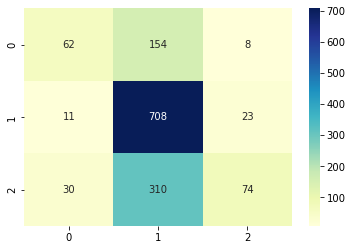

In [187]:
ax_blob = sns.heatmap(cm_knn_blob, annot = True, fmt = "d", cmap = "YlGnBu")

***

In [188]:
# menggunakan TFIDF
akurasi_blob2 = []

for k in neighbors:
    vectorizer = TfidfVectorizer()
    X_train_vec_blob = vectorizer.fit_transform(X_train_blob)
    X_test_vec_blob = vectorizer.transform(X_test_blob)
    knn_blob2 = KNeighborsClassifier(n_neighbors = k)
    knn_blob2.fit(X_train_vec_blob, y_train_blob)
    knn_score_blob2 = knn_blob2.score(X_test_vec_blob, y_test_blob)
    akurasi_blob2.append(knn_score_blob2.mean())

The optimal number of neighbors is 13


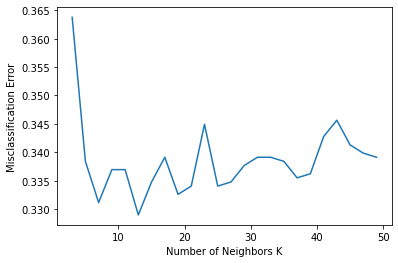

In [189]:
mse_blob2 = [1 - x for x in akurasi_blob2]

# determining best k
optimal_k_blob2 = neighbors[mse_blob2.index(min(mse_blob2))]
print("The optimal number of neighbors is {}".format(optimal_k_blob2))

# plot misclassification error vs k
plt.plot(neighbors, mse_blob2)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Misclassification Error")
plt.show()


In [190]:
X_train_vec_blob = vectorizer.fit_transform(X_train_blob)
X_test_vec_blob = vectorizer.transform(X_test_blob)
knn_blob2 = KNeighborsClassifier(n_neighbors = 13)
knn_blob2.fit(X_train_vec_blob, y_train_blob)
knn_score_blob2 = knn_blob2.score(X_test_vec_blob, y_test_blob)

print("Akurasi Model KNN Classifier (TextBlob) with TFIDFVectorizer")
print(knn_score_blob2)
y_pred_knn_blob2 = knn_blob2.predict(X_test_vec_blob)

Akurasi Model KNN Classifier (TextBlob) with TFIDFVectorizer
0.6710144927536232


In [191]:
#Confusion matrix
cm_knn_blob2 = confusion_matrix(y_test_blob, y_pred_knn_blob2)
cm_knn_blob2

array([[ 80, 126,  18],
       [ 10, 698,  34],
       [ 31, 235, 148]], dtype=int64)

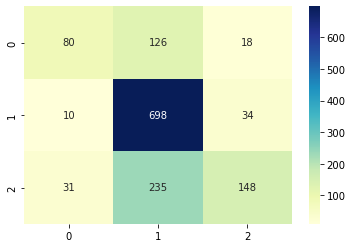

In [192]:
ax_blob2 = sns.heatmap(cm_knn_blob2, annot = True, fmt = "d", cmap = "YlGnBu")

Sama seperti sebelumnya, pada TextBlob, Dari hasil tersebut dapat diperhatikan bahwa model KNN yang dibangun dengan TFIDF vectorizer sedikit lebih baik tingkat akurasinya dibandingkan dengan Count Vectorizer.

### E.3. Perbandingan Model

Berdasarkan kombinasi di atas, hasilnya dibuatkan perbandingan sebagai berikut

In [193]:
myTable3 = PrettyTable(["Pendekatan Sentimen", "Vectorizer", "Akurasi KNN"])

myTable3.add_row(["Vader", "Count", round(knn_score_vader, 2)])
myTable3.add_row(["Vader", "TFIDF", round(knn_score_vader2, 2)])
myTable3.add_row(["TextBlob", "Count", round(knn_score_blob, 2)])
myTable3.add_row(["TextBlob", "TFIDF", round(knn_score_blob2, 2)])

print(myTable3)

+---------------------+------------+-------------+
| Pendekatan Sentimen | Vectorizer | Akurasi KNN |
+---------------------+------------+-------------+
|        Vader        |   Count    |     0.64    |
|        Vader        |   TFIDF    |     0.66    |
|       TextBlob      |   Count    |     0.61    |
|       TextBlob      |   TFIDF    |     0.67    |
+---------------------+------------+-------------+


Berdasarkan hasil tersebut, dengan menggunakan metode KNN, tingkat akurasi berkisar antara 61-67%. Tingkat akurasi tertinggi pada model KNN adalah data hasil analisis sentimen dengan menggunakan pendekatan TextBlob dan metode vectorizer berupa TFIDF. 

***

## FINISH

***